# YOLO椎体骨折検出 - バウンディングボックス可視化

このノートブックは以下を行います：
1. 変換されたYOLO形式データセットの読み込み
2. 元のNIfTI画像とバウンディングボックスの可視化
3. アノテーション品質の確認
4. 骨折マスクとバウンディングボックスの比較

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import nibabel as nib
from pathlib import Path
import random
import seaborn as sns
from PIL import Image
import warnings
import japanize_matplotlib
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (15, 10)

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 1. データパスの設定

In [15]:
# データパスの設定
base_dir = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae_saka/Sakaguchi_file")
yolo_dataset_dir = base_dir / "YOLO_datasets" / "vertebrae_fracture"
original_data_dir = base_dir / "slice_train" / "axial"
processed_data_dir = base_dir / "processed_train"

# パスの存在確認
print(f"ベースディレクトリ: {base_dir.exists()}")
print(f"YOLOデータセット: {yolo_dataset_dir.exists()}")
print(f"元データ: {original_data_dir.exists()}")
print(f"処理済みデータ: {processed_data_dir.exists()}")

ベースディレクトリ: True
YOLOデータセット: True
元データ: True
処理済みデータ: True


## 2. YOLO形式データの読み込み

In [16]:
def load_yolo_dataset(split='train'):
    """YOLO形式データセットを読み込み"""
    images_dir = yolo_dataset_dir / split / 'images'
    labels_dir = yolo_dataset_dir / split / 'labels'
    
    if not images_dir.exists() or not labels_dir.exists():
        print(f"Warning: {split} データセットが見つかりません")
        return [], []
    
    # 画像ファイルリストを取得
    image_files = list(images_dir.glob('*.jpg'))
    
    dataset = []
    for img_file in image_files:
        label_file = labels_dir / (img_file.stem + '.txt')
        
        # ラベルファイルの読み込み
        bboxes = []
        if label_file.exists():
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        center_x = float(parts[1])
                        center_y = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        bboxes.append((class_id, center_x, center_y, width, height))
        
        dataset.append({
            'image_path': img_file,
            'label_path': label_file,
            'bboxes': bboxes,
            'has_fracture': len(bboxes) > 0
        })
    
    return dataset

# データセットを読み込み
train_dataset = load_yolo_dataset('train')
val_dataset = load_yolo_dataset('val')
test_dataset = load_yolo_dataset('test')

print(f"訓練データ: {len(train_dataset)} 画像")
print(f"検証データ: {len(val_dataset)} 画像")
print(f"テストデータ: {len(test_dataset)} 画像")

訓練データ: 37367 画像
検証データ: 10843 画像
テストデータ: 11296 画像


## 3. データセット統計

In [17]:
def analyze_dataset_stats(dataset, split_name):
    """データセットの統計情報を分析"""
    if not dataset:
        print(f"{split_name}: データなし")
        return
    
    total_images = len(dataset)
    fracture_images = sum(1 for item in dataset if item['has_fracture'])
    normal_images = total_images - fracture_images
    
    total_bboxes = sum(len(item['bboxes']) for item in dataset)
    
    print(f"\n=== {split_name} データセット統計 ===")
    print(f"総画像数: {total_images}")
    print(f"骨折画像: {fracture_images} ({fracture_images/total_images*100:.1f}%)")
    print(f"正常画像: {normal_images} ({normal_images/total_images*100:.1f}%)")
    print(f"総バウンディングボックス数: {total_bboxes}")
    if fracture_images > 0:
        print(f"骨折画像あたりの平均BBox数: {total_bboxes/fracture_images:.2f}")
    
    # バウンディングボックスサイズの分布
    bbox_sizes = []
    for item in dataset:
        for bbox in item['bboxes']:
            _, _, _, width, height = bbox
            bbox_sizes.append((width, height))
    
    if bbox_sizes:
        widths, heights = zip(*bbox_sizes)
        print(f"BBox幅の統計: 平均={np.mean(widths):.4f}, 中央値={np.median(widths):.4f}, 範囲=[{np.min(widths):.4f}, {np.max(widths):.4f}]")
        print(f"BBox高さの統計: 平均={np.mean(heights):.4f}, 中央値={np.median(heights):.4f}, 範囲=[{np.min(heights):.4f}, {np.max(heights):.4f}]")

# 各データセットの統計を表示
analyze_dataset_stats(train_dataset, "訓練")
analyze_dataset_stats(val_dataset, "検証")
analyze_dataset_stats(test_dataset, "テスト")


=== 訓練 データセット統計 ===
総画像数: 37367
骨折画像: 3388 (9.1%)
正常画像: 33979 (90.9%)
総バウンディングボックス数: 3388
骨折画像あたりの平均BBox数: 1.00
BBox幅の統計: 平均=0.2129, 中央値=0.1908, 範囲=[0.0462, 0.6000]
BBox高さの統計: 平均=0.2396, 中央値=0.2193, 範囲=[0.0556, 0.7443]

=== 検証 データセット統計 ===
総画像数: 10843
骨折画像: 486 (4.5%)
正常画像: 10357 (95.5%)
総バウンディングボックス数: 486
骨折画像あたりの平均BBox数: 1.00
BBox幅の統計: 平均=0.2353, 中央値=0.2440, 範囲=[0.0600, 0.4202]
BBox高さの統計: 平均=0.3405, 中央値=0.3869, 範囲=[0.0480, 0.6050]

=== テスト データセット統計 ===
総画像数: 11296
骨折画像: 873 (7.7%)
正常画像: 10423 (92.3%)
総バウンディングボックス数: 873
骨折画像あたりの平均BBox数: 1.00
BBox幅の統計: 平均=0.2155, 中央値=0.1709, 範囲=[0.0670, 0.5769]
BBox高さの統計: 平均=0.2390, 中央値=0.1921, 範囲=[0.0670, 0.5702]


## 4. バウンディングボックス可視化関数

In [18]:
def yolo_to_pixel_coords(bbox, img_width, img_height):
    """YOLO形式座標をピクセル座標に変換"""
    class_id, center_x, center_y, width, height = bbox
    
    # ピクセル座標に変換
    x_center = center_x * img_width
    y_center = center_y * img_height
    box_width = width * img_width
    box_height = height * img_height
    
    # 左上角の座標を計算
    x1 = int(x_center - box_width / 2)
    y1 = int(y_center - box_height / 2)
    x2 = int(x_center + box_width / 2)
    y2 = int(y_center + box_height / 2)
    
    return x1, y1, x2, y2

def visualize_bbox(dataset_item, ax=None, title=None):
    """単一画像のバウンディングボックスを可視化"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # 画像を読み込み
    image = cv2.imread(str(dataset_item['image_path']))
    if image is None:
        print(f"画像が読み込めません: {dataset_item['image_path']}")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    
    # 画像を表示
    ax.imshow(image)
    
    # バウンディングボックスを描画
    for i, bbox in enumerate(dataset_item['bboxes']):
        x1, y1, x2, y2 = yolo_to_pixel_coords(bbox, width, height)
        
        # 矩形を描画
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # ラベルを描画
        ax.text(x1, y1-5, f'Fracture {i+1}', 
                color='red', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # タイトルを設定
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    else:
        filename = dataset_item['image_path'].stem
        bbox_count = len(dataset_item['bboxes'])
        ax.set_title(f'{filename} (BBox: {bbox_count})', fontsize=14)
    
    ax.axis('off')
    
    return ax

print("可視化関数の定義完了")

可視化関数の定義完了


## 5. サンプル画像の可視化

訓練データ: 骨折画像 3388, 正常画像 33979


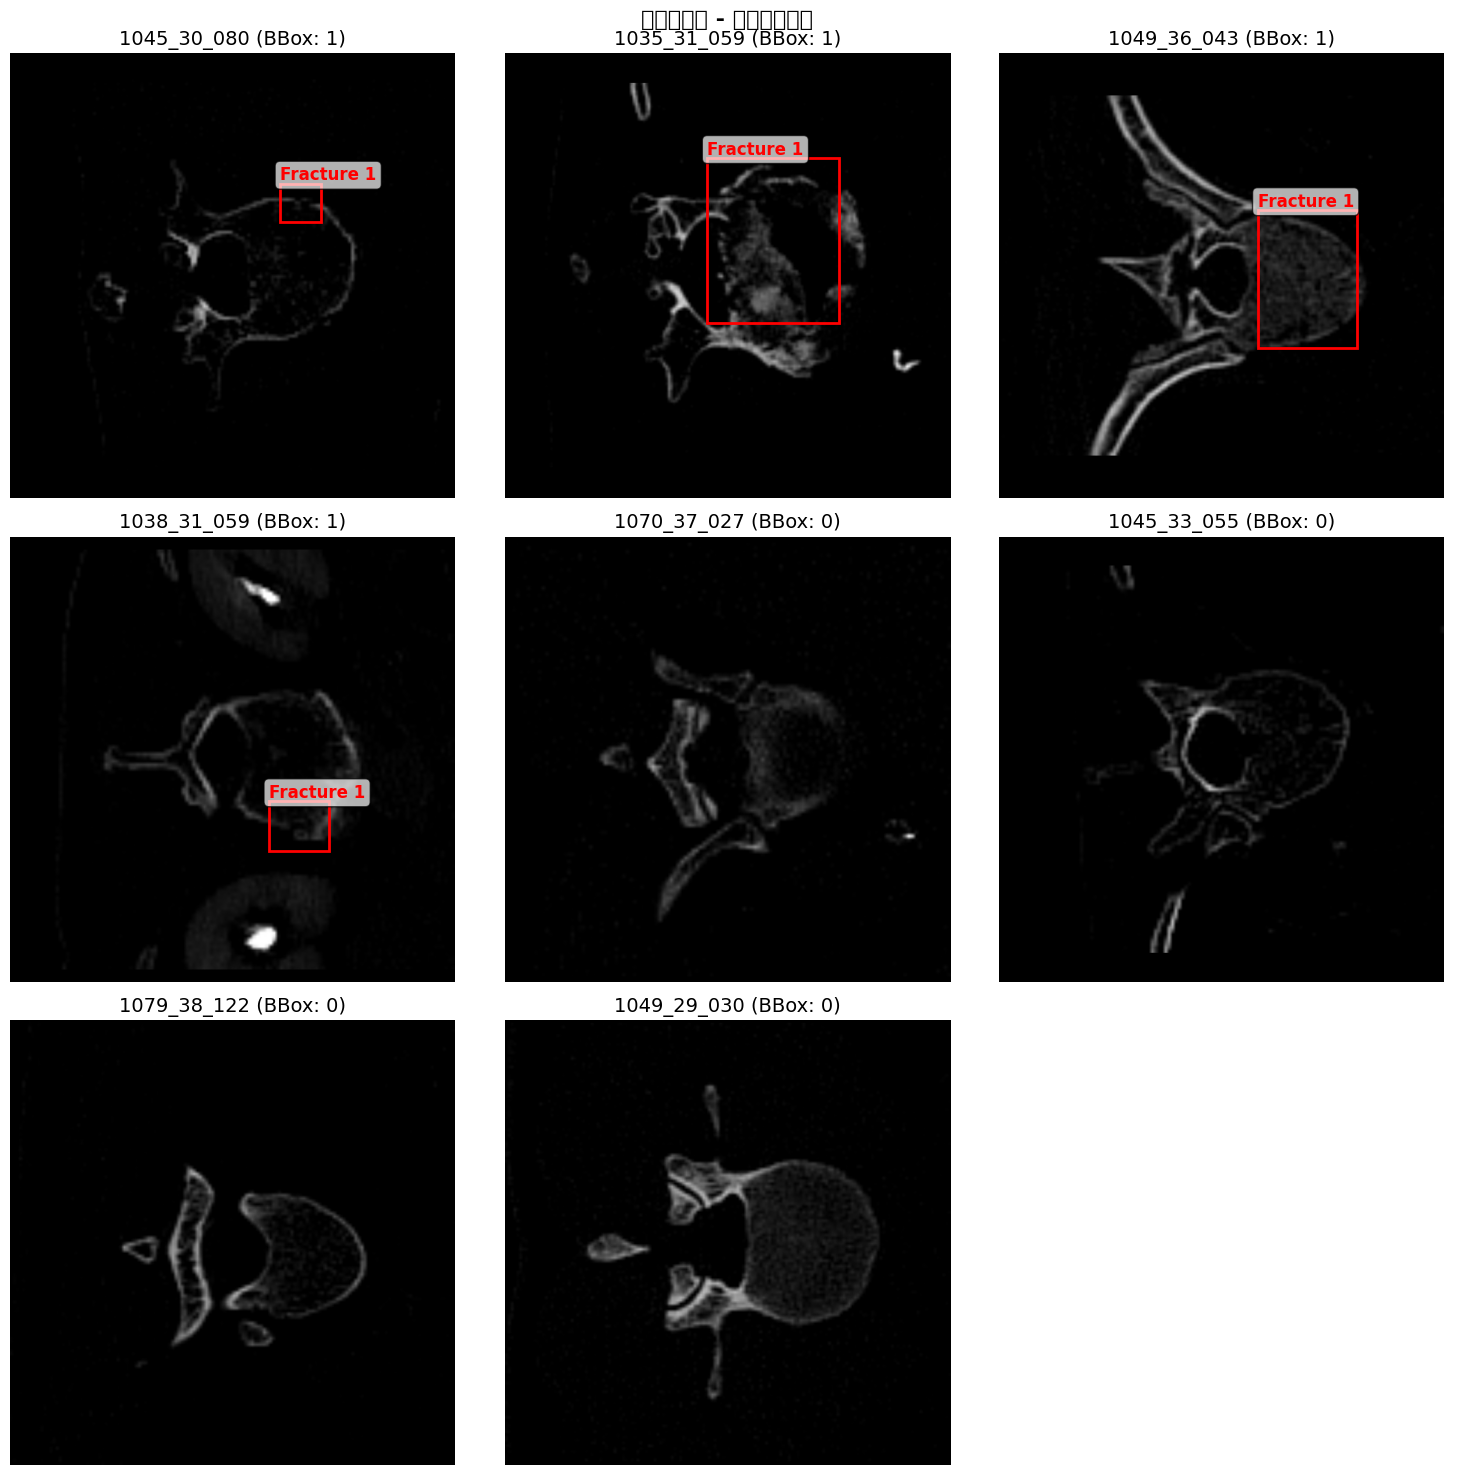

In [25]:
def visualize_sample_images(dataset, title, num_samples=9):
    """サンプル画像を可視化"""
    if not dataset:
        print(f"{title}: データが見つかりません")
        return
    
    # 骨折画像と正常画像を分離
    fracture_samples = [item for item in dataset if item['has_fracture']]
    normal_samples = [item for item in dataset if not item['has_fracture']]
    
    print(f"{title}: 骨折画像 {len(fracture_samples)}, 正常画像 {len(normal_samples)}")
    
    # サンプルを選択
    samples = []
    if fracture_samples:
        samples.extend(random.sample(fracture_samples, min(num_samples//2, len(fracture_samples))))
    if normal_samples:
        samples.extend(random.sample(normal_samples, min(num_samples//2, len(normal_samples))))
    
    if not samples:
        print("表示するサンプルがありません")
        return
    
    # グリッド表示
    rows = int(np.ceil(len(samples) / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(samples):
        row = i // 3
        col = i % 3
        
        if row < rows and col < 3:
            visualize_bbox(sample, axes[row, col])
    
    # 未使用の軸を非表示
    for i in range(len(samples), rows * 3):
        row = i // 3
        col = i % 3
        if row < rows and col < 3:
            axes[row, col].axis('off')
    
    plt.suptitle(f'{title} - サンプル画像', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 訓練データのサンプル可視化
visualize_sample_images(train_dataset, "訓練データ", 9)

## 6. 特定の患者/椎体の詳細分析

条件に一致するサンプル数: 152
骨折あり: 24, 正常: 128


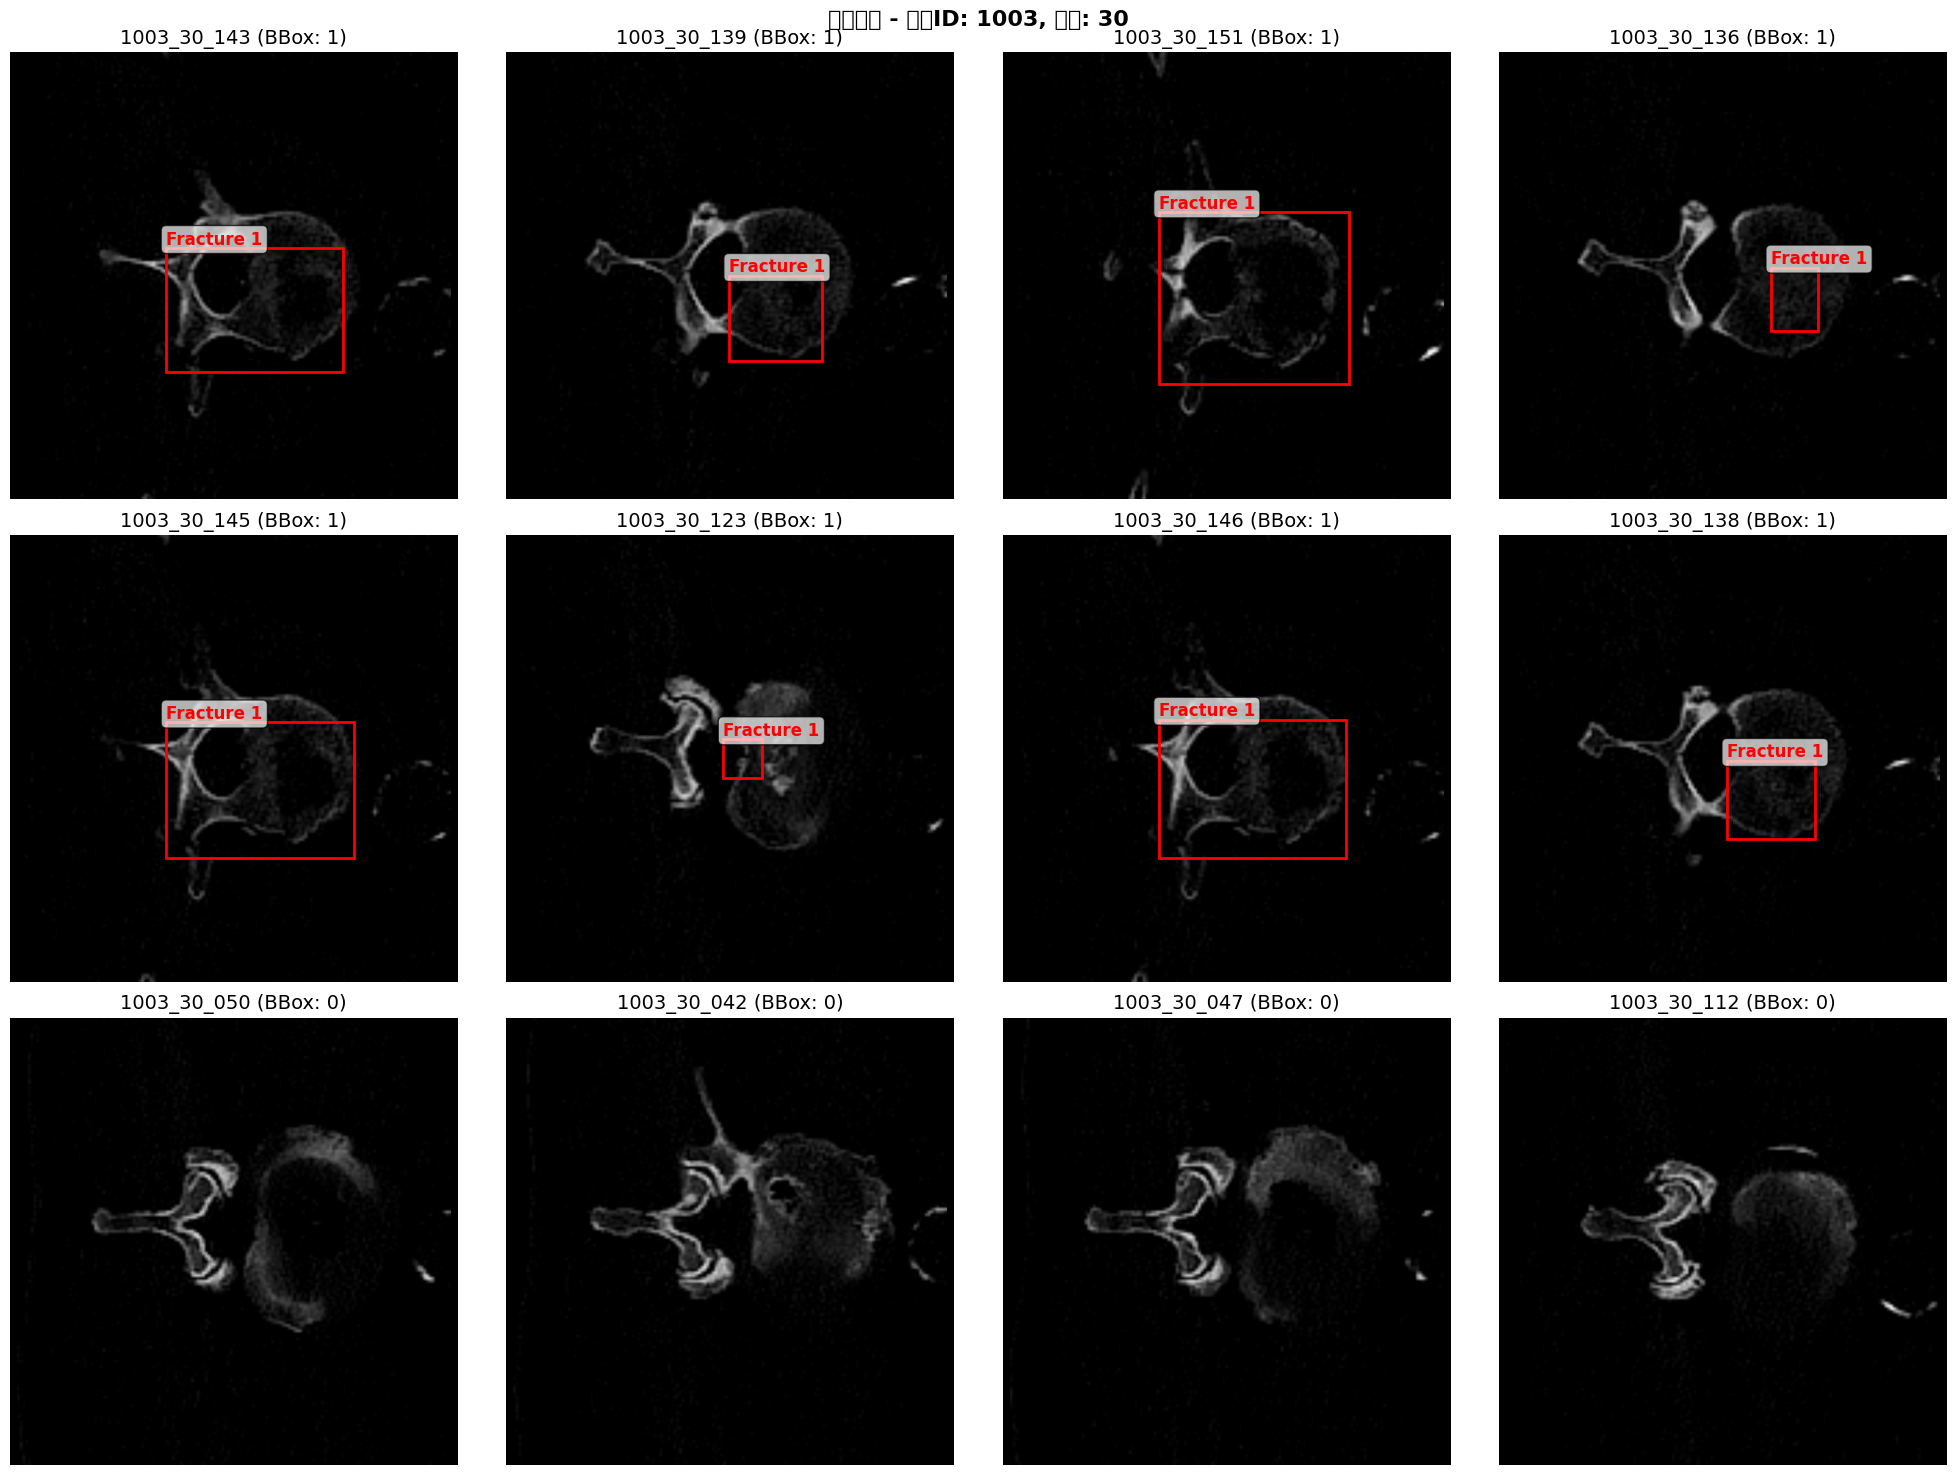

In [26]:
def analyze_specific_case(dataset, patient_id=None, vertebra=None):
    """特定の患者または椎体の詳細分析"""
    if not dataset:
        return
    
    # フィルタリング
    filtered_samples = []
    for item in dataset:
        filename = item['image_path'].stem
        # ファイル名から患者ID、椎体、スライス番号を抽出
        parts = filename.split('_')
        if len(parts) >= 3:
            case_id = parts[0]
            vert_id = parts[1]
            
            match = True
            if patient_id and case_id != str(patient_id):
                match = False
            if vertebra and vert_id != str(vertebra):
                match = False
            
            if match:
                filtered_samples.append(item)
    
    if not filtered_samples:
        print(f"条件に一致するサンプルが見つかりません (患者ID: {patient_id}, 椎体: {vertebra})")
        return
    
    print(f"条件に一致するサンプル数: {len(filtered_samples)}")
    
    # 骨折ありのサンプルを優先表示
    fracture_samples = [item for item in filtered_samples if item['has_fracture']]
    normal_samples = [item for item in filtered_samples if not item['has_fracture']]
    
    print(f"骨折あり: {len(fracture_samples)}, 正常: {len(normal_samples)}")
    
    # 最大12個のサンプルを表示
    display_samples = fracture_samples[:8] + normal_samples[:4]
    
    if display_samples:
        rows = int(np.ceil(len(display_samples) / 4))
        fig, axes = plt.subplots(rows, 4, figsize=(20, 5*rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, sample in enumerate(display_samples):
            row = i // 4
            col = i % 4
            
            if row < rows and col < 4:
                visualize_bbox(sample, axes[row, col])
        
        # 未使用の軸を非表示
        for i in range(len(display_samples), rows * 4):
            row = i // 4
            col = i % 4
            if row < rows and col < 4:
                axes[row, col].axis('off')
        
        plt.suptitle(f'詳細分析 - 患者ID: {patient_id}, 椎体: {vertebra}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# 患者1003、椎体30の詳細分析（骨折が確認されているケース）
analyze_specific_case(train_dataset, patient_id=1003, vertebra=30)

## 7. 元の骨折マスクとの比較

比較対象: 1046_27_125


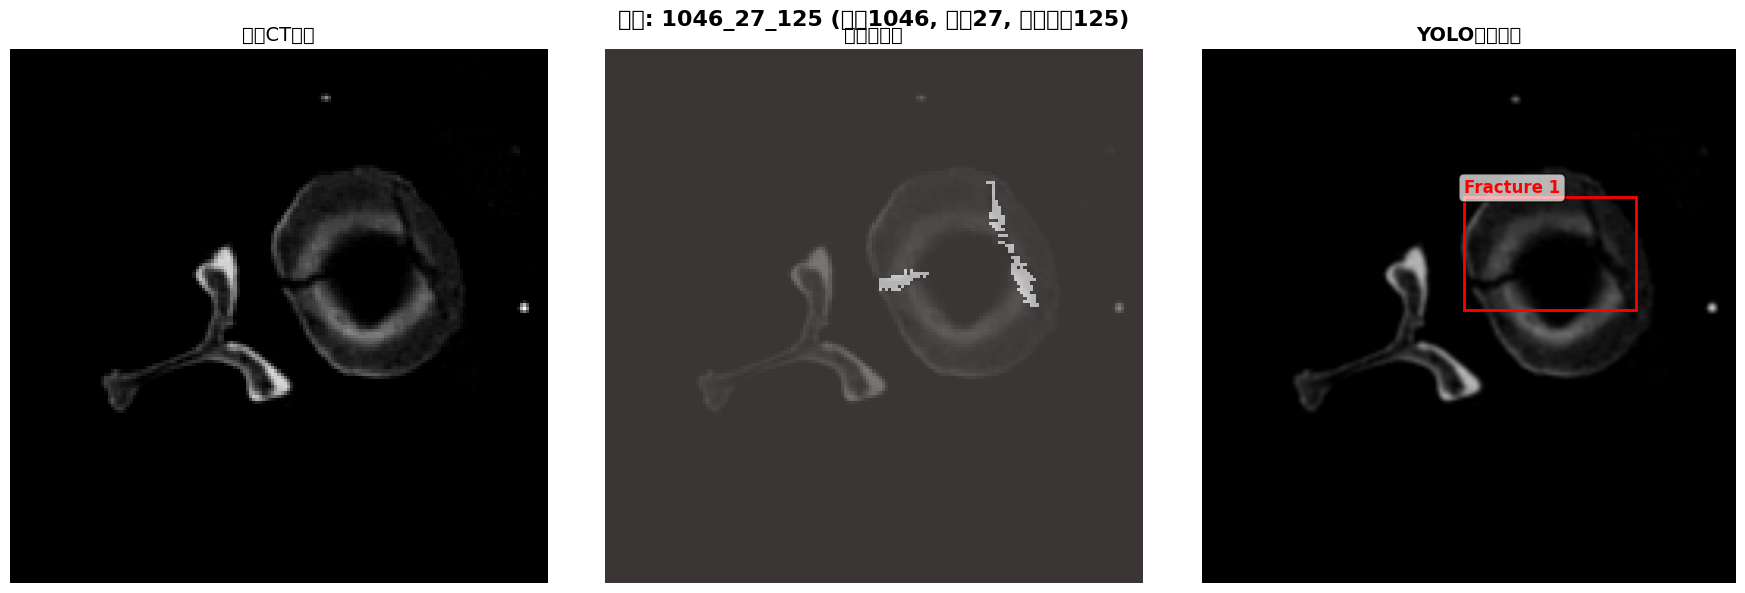

骨折マスク統計:
  非零ピクセル数: 171
  マスク値範囲: [0.00, 1.00]
  YOLOバウンディングボックス数: 1


In [27]:
def compare_with_original_mask(dataset_item):
    """元の骨折マスクとバウンディングボックスを比較"""
    # ファイル名から情報を抽出
    filename = dataset_item['image_path'].stem
    parts = filename.split('_')
    
    if len(parts) < 3:
        print(f"ファイル名形式が不正: {filename}")
        return
    
    patient_id = parts[0]
    vertebra = parts[1]
    slice_idx = int(parts[2])
    
    # 元の骨折マスクを読み込み
    mask_path = processed_data_dir / f"inp{patient_id}" / vertebra / f"cut_ans{patient_id}.nii"
    
    if not mask_path.exists():
        print(f"骨折マスクが見つかりません: {mask_path}")
        return
    
    try:
        mask_nifti = nib.load(str(mask_path))
        mask_data = mask_nifti.get_fdata()
        
        if slice_idx >= mask_data.shape[2]:
            print(f"スライスインデックスが範囲外: {slice_idx} >= {mask_data.shape[2]}")
            return
        
        slice_mask = mask_data[:, :, slice_idx]
        
        # 元のCT画像も読み込み
        ct_path = processed_data_dir / f"inp{patient_id}" / vertebra / f"cut_inp{patient_id}.nii.gz"
        if ct_path.exists():
            ct_nifti = nib.load(str(ct_path))
            ct_data = ct_nifti.get_fdata()
            ct_slice = ct_data[:, :, slice_idx]
            
            # HU値を正規化
            ct_normalized = np.clip(ct_slice, 100, 2000)
            ct_normalized = (ct_normalized - 100) / 1900 * 255
            ct_normalized = ct_normalized.astype(np.uint8)
        else:
            ct_normalized = None
        
        # 可視化
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. 元のCT画像
        if ct_normalized is not None:
            axes[0].imshow(ct_normalized, cmap='gray')
            axes[0].set_title('元のCT画像', fontsize=14)
        else:
            axes[0].text(0.5, 0.5, 'CT画像なし', ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title('元のCT画像（未取得）', fontsize=14)
        
        # 2. 骨折マスク
        axes[1].imshow(slice_mask, cmap='hot', alpha=0.7)
        if ct_normalized is not None:
            axes[1].imshow(ct_normalized, cmap='gray', alpha=0.3)
        axes[1].set_title('骨折マスク', fontsize=14)
        
        # 3. YOLO変換画像 + バウンディングボックス
        visualize_bbox(dataset_item, axes[2], 'YOLO変換画像')
        
        for ax in axes:
            ax.axis('off')
        
        plt.suptitle(f'比較: {filename} (患者{patient_id}, 椎体{vertebra}, スライス{slice_idx})', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 統計情報
        print(f"骨折マスク統計:")
        print(f"  非零ピクセル数: {np.sum(slice_mask > 0)}")
        print(f"  マスク値範囲: [{np.min(slice_mask):.2f}, {np.max(slice_mask):.2f}]")
        print(f"  YOLOバウンディングボックス数: {len(dataset_item['bboxes'])}")
        
    except Exception as e:
        print(f"エラー: {e}")

# 骨折ありのサンプルで比較
fracture_samples = [item for item in train_dataset if item['has_fracture']]
if fracture_samples:
    sample = random.choice(fracture_samples)
    print(f"比較対象: {sample['image_path'].stem}")
    compare_with_original_mask(sample)
else:
    print("骨折サンプルが見つかりません")

## 8. バウンディングボックスサイズ分布の分析

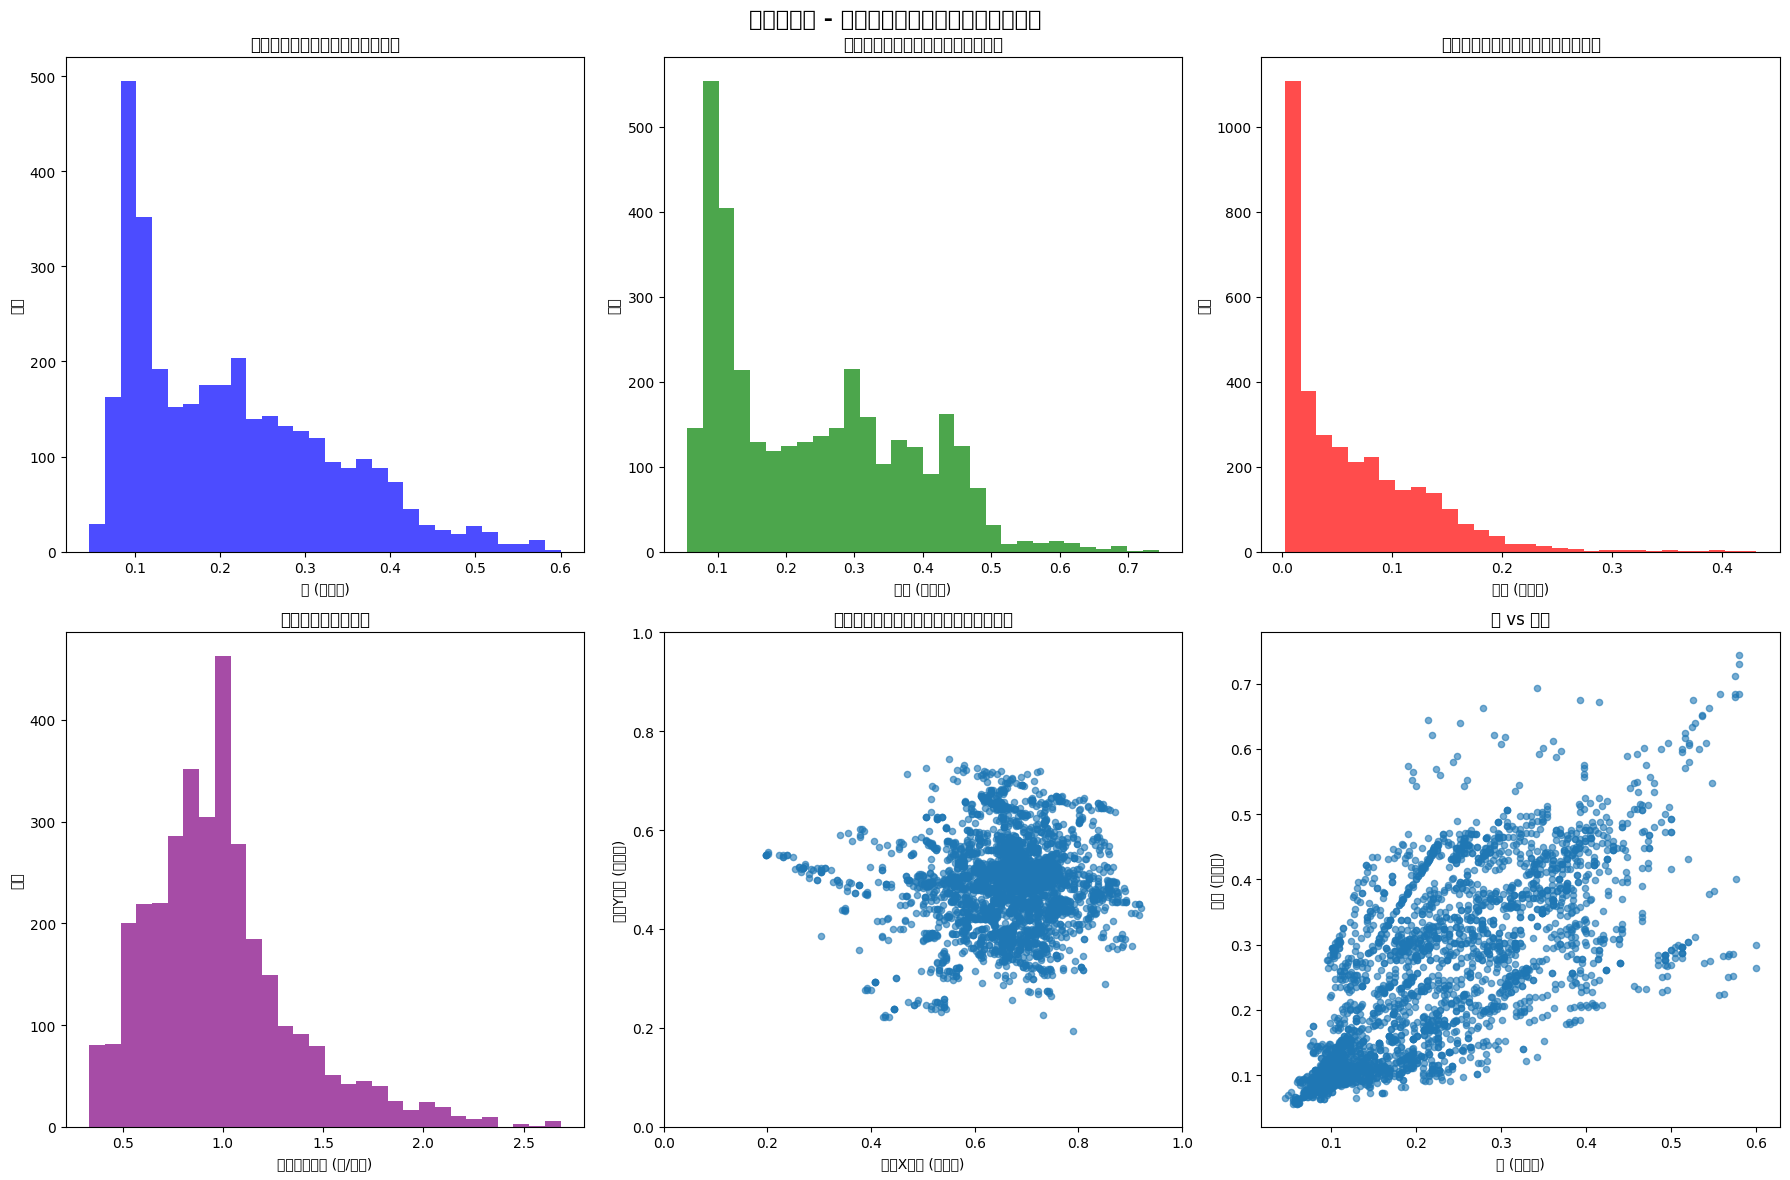


訓練データ - 統計サマリー:
総バウンディングボックス数: 3388
幅: 平均=0.2129, 標準偏差=0.1153
高さ: 平均=0.2396, 標準偏差=0.1391
面積: 平均=0.062776, 標準偏差=0.061198
アスペクト比: 平均=0.98, 標準偏差=0.37


In [28]:
def analyze_bbox_distribution(dataset, title):
    """バウンディングボックスサイズ分布を分析"""
    if not dataset:
        return
    
    # バウンディングボックスデータを収集
    bbox_data = []
    for item in dataset:
        for bbox in item['bboxes']:
            class_id, center_x, center_y, width, height = bbox
            bbox_data.append({
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height > 0 else 0,
                'center_x': center_x,
                'center_y': center_y
            })
    
    if not bbox_data:
        print(f"{title}: バウンディングボックスなし")
        return
    
    df = pd.DataFrame(bbox_data)
    
    # 分布の可視化
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. 幅の分布
    axes[0, 0].hist(df['width'], bins=30, alpha=0.7, color='blue')
    axes[0, 0].set_title('バウンディングボックス幅の分布')
    axes[0, 0].set_xlabel('幅 (正規化)')
    axes[0, 0].set_ylabel('頻度')
    
    # 2. 高さの分布
    axes[0, 1].hist(df['height'], bins=30, alpha=0.7, color='green')
    axes[0, 1].set_title('バウンディングボックス高さの分布')
    axes[0, 1].set_xlabel('高さ (正規化)')
    axes[0, 1].set_ylabel('頻度')
    
    # 3. 面積の分布
    axes[0, 2].hist(df['area'], bins=30, alpha=0.7, color='red')
    axes[0, 2].set_title('バウンディングボックス面積の分布')
    axes[0, 2].set_xlabel('面積 (正規化)')
    axes[0, 2].set_ylabel('頻度')
    
    # 4. アスペクト比の分布
    axes[1, 0].hist(df['aspect_ratio'], bins=30, alpha=0.7, color='purple')
    axes[1, 0].set_title('アスペクト比の分布')
    axes[1, 0].set_xlabel('アスペクト比 (幅/高さ)')
    axes[1, 0].set_ylabel('頻度')
    
    # 5. 中心位置の分布
    axes[1, 1].scatter(df['center_x'], df['center_y'], alpha=0.6, s=20)
    axes[1, 1].set_title('バウンディングボックス中心位置の分布')
    axes[1, 1].set_xlabel('中心X座標 (正規化)')
    axes[1, 1].set_ylabel('中心Y座標 (正規化)')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    
    # 6. 幅×高さの散布図
    axes[1, 2].scatter(df['width'], df['height'], alpha=0.6, s=20)
    axes[1, 2].set_title('幅 vs 高さ')
    axes[1, 2].set_xlabel('幅 (正規化)')
    axes[1, 2].set_ylabel('高さ (正規化)')
    
    plt.suptitle(f'{title} - バウンディングボックス分布分析', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 統計サマリー
    print(f"\n{title} - 統計サマリー:")
    print(f"総バウンディングボックス数: {len(df)}")
    print(f"幅: 平均={df['width'].mean():.4f}, 標準偏差={df['width'].std():.4f}")
    print(f"高さ: 平均={df['height'].mean():.4f}, 標準偏差={df['height'].std():.4f}")
    print(f"面積: 平均={df['area'].mean():.6f}, 標準偏差={df['area'].std():.6f}")
    print(f"アスペクト比: 平均={df['aspect_ratio'].mean():.2f}, 標準偏差={df['aspect_ratio'].std():.2f}")

# 訓練データの分析
analyze_bbox_distribution(train_dataset, "訓練データ")

## 9. 品質チェック

In [29]:
def quality_check(dataset, title):
    """データセットの品質をチェック"""
    if not dataset:
        return
    
    print(f"\n=== {title} 品質チェック ===")
    
    # 基本統計
    total_images = len(dataset)
    images_with_bbox = sum(1 for item in dataset if item['has_fracture'])
    images_without_bbox = total_images - images_with_bbox
    
    print(f"総画像数: {total_images}")
    print(f"バウンディングボックスあり: {images_with_bbox}")
    print(f"バウンディングボックスなし: {images_without_bbox}")
    
    # 異常値チェック
    bbox_issues = []
    very_small_bbox = []
    very_large_bbox = []
    
    for item in dataset:
        for bbox in item['bboxes']:
            class_id, center_x, center_y, width, height = bbox
            
            # 座標範囲チェック
            if not (0 <= center_x <= 1 and 0 <= center_y <= 1):
                bbox_issues.append(f"座標範囲外: {item['image_path'].stem}")
            
            # サイズチェック
            if width < 0.001 or height < 0.001:
                very_small_bbox.append(f"極小BBox: {item['image_path'].stem} (w={width:.4f}, h={height:.4f})")
            elif width > 0.5 or height > 0.5:
                very_large_bbox.append(f"大型BBox: {item['image_path'].stem} (w={width:.4f}, h={height:.4f})")
    
    print(f"\n潜在的な問題:")
    print(f"座標範囲外: {len(bbox_issues)}")
    print(f"極小バウンディングボックス: {len(very_small_bbox)}")
    print(f"大型バウンディングボックス: {len(very_large_bbox)}")
    
    # 詳細表示（最大5件）
    if bbox_issues:
        print("\n座標範囲外の例:")
        for issue in bbox_issues[:5]:
            print(f"  {issue}")
    
    if very_small_bbox:
        print("\n極小バウンディングボックスの例:")
        for issue in very_small_bbox[:5]:
            print(f"  {issue}")
    
    if very_large_bbox:
        print("\n大型バウンディングボックスの例:")
        for issue in very_large_bbox[:5]:
            print(f"  {issue}")
    
    # 品質スコア
    total_issues = len(bbox_issues) + len(very_small_bbox) + len(very_large_bbox)
    quality_score = max(0, 100 - (total_issues / total_images * 100))
    
    print(f"\n品質スコア: {quality_score:.1f}/100")
    
    return {
        'total_images': total_images,
        'images_with_bbox': images_with_bbox,
        'bbox_issues': len(bbox_issues),
        'very_small_bbox': len(very_small_bbox),
        'very_large_bbox': len(very_large_bbox),
        'quality_score': quality_score
    }

# 全データセットの品質チェック
train_quality = quality_check(train_dataset, "訓練データ")
val_quality = quality_check(val_dataset, "検証データ")
test_quality = quality_check(test_dataset, "テストデータ")


=== 訓練データ 品質チェック ===
総画像数: 37367
バウンディングボックスあり: 3388
バウンディングボックスなし: 33979

潜在的な問題:
座標範囲外: 0
極小バウンディングボックス: 0
大型バウンディングボックス: 124

大型バウンディングボックスの例:
  大型BBox: 1027_31_135 (w=0.3920, h=0.5160)
  大型BBox: 1054_33_035 (w=0.5120, h=0.2880)
  大型BBox: 1054_33_036 (w=0.5120, h=0.2880)
  大型BBox: 1027_32_089 (w=0.4593, h=0.5081)
  大型BBox: 1027_32_072 (w=0.4959, h=0.6098)

品質スコア: 99.7/100

=== 検証データ 品質チェック ===
総画像数: 10843
バウンディングボックスあり: 486
バウンディングボックスなし: 10357

潜在的な問題:
座標範囲外: 0
極小バウンディングボックス: 0
大型バウンディングボックス: 97

大型バウンディングボックスの例:
  大型BBox: 1016_33_016 (w=0.2773, h=0.5882)
  大型BBox: 1016_32_194 (w=0.2560, h=0.5600)
  大型BBox: 1010_29_091 (w=0.3827, h=0.5255)
  大型BBox: 1010_31_011 (w=0.2656, h=0.5104)
  大型BBox: 1010_31_007 (w=0.4062, h=0.5052)

品質スコア: 99.1/100

=== テストデータ 品質チェック ===
総画像数: 11296
バウンディングボックスあり: 873
バウンディングボックスなし: 10423

潜在的な問題:
座標範囲外: 0
極小バウンディングボックス: 0
大型バウンディングボックス: 78

大型バウンディングボックスの例:
  大型BBox: 1025_31_079 (w=0.5273, h=0.4182)
  大型BBox: 1039_38_003 (w=0.5118, h=0.3937)
  大型BBox: 10

## 10. 推奨事項

In [30]:
print("\n=== バウンディングボックス品質評価まとめ ===")
print("\n1. データセット統計:")
if train_quality:
    print(f"   訓練データ: {train_quality['images_with_bbox']}/{train_quality['total_images']} 画像に骨折BBox")
if val_quality:
    print(f"   検証データ: {val_quality['images_with_bbox']}/{val_quality['total_images']} 画像に骨折BBox")
if test_quality:
    print(f"   テストデータ: {test_quality['images_with_bbox']}/{test_quality['total_images']} 画像に骨折BBox")

print("\n2. 品質スコア:")
if train_quality:
    print(f"   訓練データ: {train_quality['quality_score']:.1f}/100")
if val_quality:
    print(f"   検証データ: {val_quality['quality_score']:.1f}/100")
if test_quality:
    print(f"   テストデータ: {test_quality['quality_score']:.1f}/100")

print("\n3. 推奨改善事項:")
print("   - 極小バウンディングボックスは学習に影響する可能性があります")
print("   - 医療画像の特性を考慮して、最小BBoxサイズを調整することを検討してください")
print("   - データ拡張時にBBoxの整合性を保つよう注意してください")
print("   - 不均衡なデータ分布の場合、重み付きサンプリングを検討してください")

print("\n4. 次のステップ:")
print("   - YOLO訓練を開始する前に、いくつかのサンプルで手動検証することを推奨")
print("   - 訓練中は検証データでの性能推移を監視")
print("   - 推論結果と元の医療画像を比較して精度を確認")


=== バウンディングボックス品質評価まとめ ===

1. データセット統計:
   訓練データ: 3388/37367 画像に骨折BBox
   検証データ: 486/10843 画像に骨折BBox
   テストデータ: 873/11296 画像に骨折BBox

2. 品質スコア:
   訓練データ: 99.7/100
   検証データ: 99.1/100
   テストデータ: 99.3/100

3. 推奨改善事項:
   - 極小バウンディングボックスは学習に影響する可能性があります
   - 医療画像の特性を考慮して、最小BBoxサイズを調整することを検討してください
   - データ拡張時にBBoxの整合性を保つよう注意してください
   - 不均衡なデータ分布の場合、重み付きサンプリングを検討してください

4. 次のステップ:
   - YOLO訓練を開始する前に、いくつかのサンプルで手動検証することを推奨
   - 訓練中は検証データでの性能推移を監視
   - 推論結果と元の医療画像を比較して精度を確認
